In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_train = pd.read_csv("./train_clean.csv",index_col = 0)
df_test = pd.read_csv("./test_clean.csv", index_col=0)


In [9]:
df_train.head(1)

,favorite_count,full_text,hashtags,retweet_count,year,party_id
0,0,kusinews one longtime viewer congressman darre...,KUSI,10,2017.0,R


In [110]:
df_test.shape

(265000, 7)

### Temporal, Partisan, Count

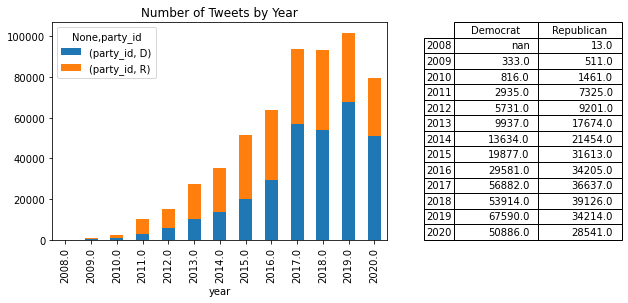

In [108]:
#num of tweets in df by year & party

train_groupby_year_party = df_train.groupby(
    by=['party_id', 'year']).count().unstack('party_id')
train_groupby_year_party = train_groupby_year_party[['hashtags']]
train_groupby_year_party.rename(columns={'hashtags':'party_id'},inplace=True)
train_groupby_year_party.plot(
    kind='bar', title='Number of Tweets by Year', stacked=True, legend=True)

plt.table(cellText=train_groupby_year_party.values, bbox=[1.2, 0, 0.5, 1], rowLabels=np.arange(2008, 2021, 1), colLabels=['Democrat','Republican']
          )

# This is somewhat unsurprising given that the entire industry was expeirencing massive user boom up in the US until very recently
# however, this does illustrate a significant imbalance within our dataset
# model would be more favourable to tweets from 2014 and onward

#we also notice that we consistently have more republican tweets up until 2017 when Democrat overtook Rupublican by large margin consistently
# this may be related to the 2016 US election which was a polarizing evcent in the American politics. 


### Hashtag Analysis

In [206]:
#prelinminary analysis of hashtag as alternative to topic indication

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df= 4000) #mindf 3
x2 = vectorizer.fit_transform(df_train['hashtags'])
y = df_train['party_id']

all_hashtags = pd.DataFrame.sparse.from_spmatrix(
    x2, columns=vectorizer.get_feature_names_out())

In [ ]:
count_hash = all_hashtags.sum(axis=0).sort_values(ascending=False)
count_hash.describe()

## all hashtags (76414)
# 75 perct less than 3 mention

## in the top 25%, 75% less than 16 mentions

## in top25% of the top 25% (top 6.25%)
#count     6205.000000
#mean       114.481386
#std        390.635258
#min         16.000000
#25 %       22.000000
#50 %       36.000000
#75 %       82.000000
#max      16954.000000

covid19         16954
sotu             7524
obamacare        7449
tcot             6553
taxreform        5987
coronavirus      5830
forthepeople     5092
aca              4475
trumpcare        4206
veterans         4144
dtype: int64


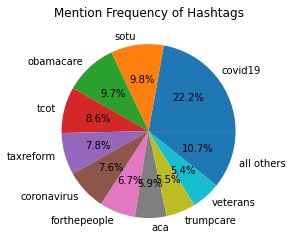

In [193]:
#hashtags with more than 4000 mentions
#mention_4000 = count_hash
mention_4000
sum_others = 76414 - mention_4000.sum()
mention_all = mention_4000.append(pd.Series([sum_others], index=['all others']))
mention_all.plot(kind='pie', ylabel='', autopct='%1.1f%%',
                 title="Mention Frequency of Hashtags")

print(mention_4000)
#covid clearly an anomaly
#some of these hashtags are very partisan, such as #tcot - "top conservatives on twitter" - 
# or #trumpcare which appears to be primarily a mockery to Trump's attempt to repeal Obamacare


In [ ]:
plt.table(cellText=train_groupby_year_party.values, bbox=[1.2, 0, 0.5, 1], rowLabels=np.arange(2008, 2021, 1), colLabels=['Democrat', 'Republican']
          )


In [2]:
#investigate 

# relabel dem and rep as 0-1

df_train.party_id = pd.Categorical(df_train.party_id)
df_train['party_id'] = df_train.party_id.cat.codes

#the favorite and retweet count have near 0 correlation with partisanship


In [4]:
df_train.corr()

,favorite_count,retweet_count,year,party_id
favorite_count,1.000000,0.756996,0.059132,-0.023679
retweet_count,0.756996,1.000000,0.045455,-0.019159
year,0.059132,0.045455,1.000000,-0.210004
party_id,-0.023679,-0.019159,-0.210004,1.000000


In [ ]:
df_train_early = df_train[df_train['year'] <= 2016]
df_train_recent = df_train[df_train['year'] > 2016]


### Simple Sentiment Calc

In [217]:
#positivity/negativity simple
#counts of positive/negative words in comment

comments_train = df_train['full_text'].tolist()  # call again
comments_test = df_test['full_text'].tolist()  # call again
simple_score_train = []  # init
simple_score_test = []  # init

#import csv using pd & convert to native list
negative_words = pd.read_csv('negative_words.csv', names=[
                             'neg'], encoding='latin-1')
negative_words = negative_words['neg'].tolist()
positive_words = pd.read_csv('positive_words.csv', names=[
                             'pos'], encoding='latin-1')
positive_words = positive_words['pos'].tolist()


In [218]:
#*TErRiBlE* nested iterative coding, but easy for my brain
#this thing took 10 minutes
scores = []
for data in [comments_train,comments_test]:
    comments = data
    simple_score = []
    for text in comments:

        text = str(text).split()  # handles float.nan case & split for token
        text_score = [0, 0]  # [0] is neg, [1] is pos

        #iterate words
        for token in text:
            #in operator is iterative
            if(token in negative_words):
                text_score[0] += 1
            if(token in positive_words):
                text_score[1] += 1

        #divide both score by total
        comment_total_word = len(text)
        #handles case when text is empty...again?? I cant be bothered to investigate this
        if(len(text) != 0):
            text_score[0] = text_score[0]/comment_total_word
            text_score[1] = text_score[1]/comment_total_word

        #print(text_score)
        simple_score.append(text_score)  # store

    scores.append(simple_score)


In [ ]:
simple_score_train = scores[0]
simple_score_test = scores[1]
simple_score_train[0]

#simple_score
#add to df
df_train['negativity_simple'] = pd.Series([x[0] for x in simple_score_train])
df_train['positivity_simple'] = pd.Series([x[1] for x in simple_score_train])

df_test['negativity_simple'] = pd.Series([x[0] for x in simple_score_test])
df_test['positivity_simple'] = pd.Series([x[1] for x in simple_score_test])


In [229]:
df_test.to_pickle('./test.pickle')
df_train.to_pickle('./train.pickle')


## finished sentiment calc

In [270]:
#prelinminary analysis of hashtag as alternative to topic indication

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df_all = df_train['hashtags'].append(df_test['hashtags'])

vectorizer = CountVectorizer(
    analyzer='word', ngram_range=(1, 1), min_df=1)  # mindf 3
vectorizer.fit(df_all)
x_train = vectorizer.transform(df_train['hashtags'])
x_test = vectorizer.transform(df_test['hashtags'])


y = df_train['party_id']

In [266]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

x_train = hstack((x_train, np.array(df_train['negativity_simple'])[:, None]))
x_train = hstack((x_train, np.array(df_train['positivity_simple'])[:, None]))
x_test = hstack((x_test, np.array(df_test['negativity_simple'])[:, None]))
x_test = hstack((x_test, np.array(df_test['positivity_simple'])[:, None]))


In [271]:
from scipy import sparse
sparse.save_npz('./hash_train', x_train)
sparse.save_npz('./hash_test', x_test)

In [268]:
x_train


<592803x93499 sparse matrix of type '<class 'numpy.float64'>'
	with 1467142 stored elements in COOrdinate format>

### note
提取每一個推的話題 -》
    1） 提取所有話題
            corpus frequent
            LSA vs LDA
            LSA: frequency
            LDA: generative -> 